"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [63]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum
import sys
sys.path.append('/media/bigdata/firing_space_plot/ephys_data')
from ephys_data import ephys_data
import visualize

In [198]:
# Some poisson spiking
length = 100
states = 3
nrns = 10
trials = 10
fit = int(1e5)
samples = 2000
idx = np.arange(length)

true_tau = np.cumsum(np.random.random((trials,states)),axis=-1)
true_tau /= np.max(true_tau,axis=-1)[...,np.newaxis]
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)

print(true_tau.shape)

state_inds = np.concatenate([np.zeros((trials,1)),true_tau],axis=-1)
state_inds = np.vectorize(np.int)(state_inds)
true_tau = true_tau[:,:-1]

print(true_tau.shape)
print(state_inds.shape)

true_lambda = np.random.random((nrns,states))
print(true_lambda.shape)
true_r = np.zeros((trials, nrns, length))

for trial_num in range(trials):
    for state_num in range(states):
        true_r[trial_num,:,state_inds[trial_num,state_num]:state_inds[trial_num,state_num+1]] = \
                        true_lambda[:,state_num][:,np.newaxis]
        
data_array = np.random.random(true_r.shape) < true_r     

(10, 3)
(10, 2)
(10, 4)
(10, 3)


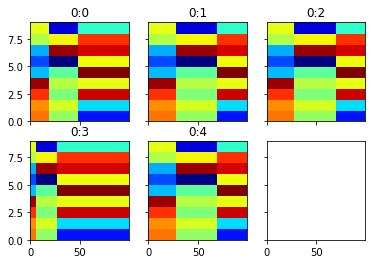

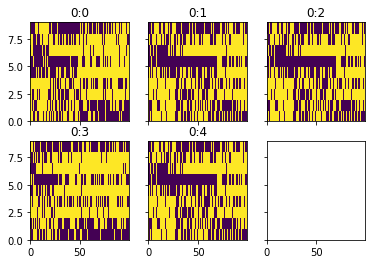

In [199]:
trial_count = 5
trial_inds = np.random.choice(np.arange(trials),5)
visualize.firing_overview(true_r[trial_inds]);
visualize.firing_overview(data_array[trial_inds], cmap='viridis');

In [200]:
mean_vals = np.array([np.mean(x,axis=-1) for x in np.array_split(data_vec,states,axis=-1)]).T
mean_vals = np.mean(mean_vals,axis=1)
print(mean_vals.shape)

(10, 3)


In [201]:
with pm.Model() as model:
    # Finite, but somewhere on the lower end, Beta prior
    a_lambda = 2
    b_lambda = 5
    lambda_latent = pm.Beta('lambda', 
                                    a_lambda, b_lambda, 
                                    shape = (nrns,states),
                                  testval = mean_vals + 1e-3)

    a = pm.HalfCauchy('a_tau', 3., shape = states - 1)
    b = pm.HalfCauchy('b_tau', 3., shape = states - 1)
    
    even_switches = np.linspace(0,1,states+1)[1:-1]
    tau_latent = pm.Beta('tau_latent', a, b, 
                         testval = even_switches,
                         shape = (trials,states-1)).sort(axis=-1)    
    
    tau = pm.Deterministic('tau', 
            idx.min() + (idx.max() - idx.min()) * tau_latent)

In [202]:
print(tau.tag.test_value.shape)

(10, 2)


In [203]:
print(idx.shape)

(100,)


In [204]:
with model:
    weight_stack = tt.nnet.sigmoid(idx[np.newaxis,:]-tau[:,:,np.newaxis])
    weight_stack = tt.concatenate([np.ones((trials,1,length)),weight_stack],axis=1)
    inverse_stack = 1 - weight_stack[:,1:]
    inverse_stack = tt.concatenate([inverse_stack, np.ones((trials,1,length))],axis=1)

    weight_stack = np.multiply(weight_stack,inverse_stack)

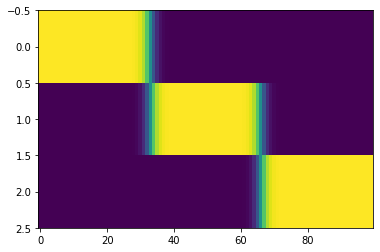

In [205]:
plt.imshow(weight_stack.tag.test_value[0],aspect='auto');

In [206]:
print(weight_stack.tag.test_value.shape)
print(lambda_latent.tag.test_value.shape)

(10, 3, 100)
(10, 3)


In [187]:
with model:
    lambda_ = tt.tensordot(weight_stack,lambda_latent, [1,1]).swapaxes(1,2)
    #lambda_ = lambda_latent.dot(weight_stack)
print(lambda_.tag.test_value.shape)

(10, 10, 100)


In [188]:
# visualize.firing_overview(true_r,cmap='viridis')
# plt.figure()
# visualize.firing_overview(lambda_.tag.test_value, cmap='viridis')
# print(true_r.shape)
# print(lambda_.tag.test_value.shape)

In [189]:
with model:
    # Add observations
    observation = pm.Bernoulli("obs", lambda_, observed=data_array)

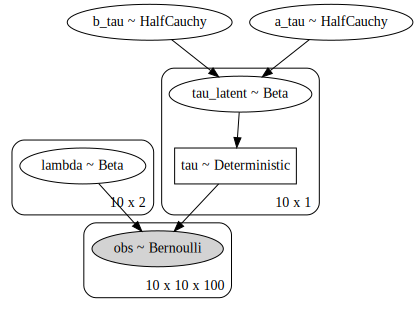

In [190]:
pm.model_to_graphviz(model)

In [191]:
with model:
    inference = pm.ADVI('full-rank')
    approx = pm.fit(n=fit, method=inference,
                   random_seed = 3,
                   obj_n_mc = 1)
    trace = approx.sample(draws=samples)

  0%|          | 0/100000 [00:00<?, ?it/s]/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Average Loss = 5,304.2: 100%|██████████| 100000/100000 [01:33<00:00, 1069.44it/s]
Finished [100%]: Average Loss = 5,304.2


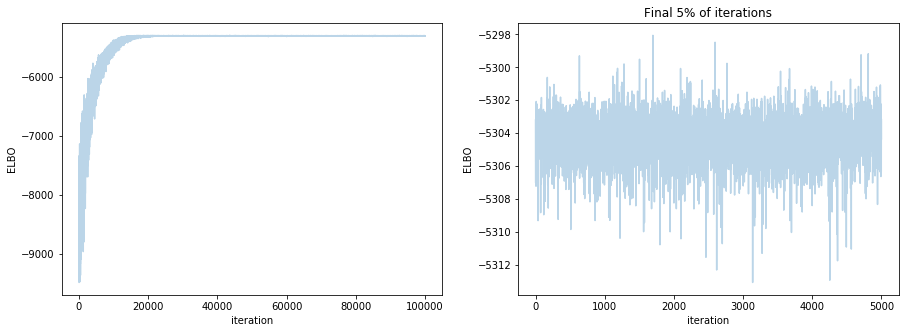

In [192]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(-approx.hist, alpha=.3)
ax[0].set_ylabel('ELBO')
ax[0].set_xlabel('iteration');

ind = int(fit - fit*0.05)
ax[1].plot(-approx.hist[ind:], alpha=.3)
ax[1].set_title('Final 5% of iterations')
ax[1].set_ylabel('ELBO')
ax[1].set_xlabel('iteration');

In [193]:
ppc = pm.sample_posterior_predictive(trace, samples = 2000, model = model)

100%|██████████| 2000/2000 [00:03<00:00, 593.04it/s]


In [194]:
trial_count = 5
trial_inds = np.random.choice(np.arange(trials),5)

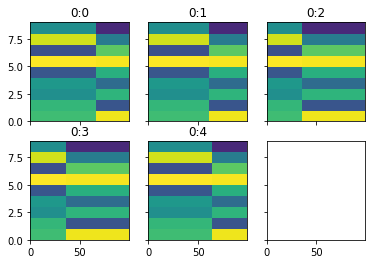

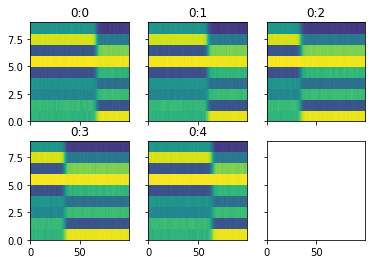

In [195]:
visualize.firing_overview(true_r[trial_inds],cmap='viridis');
visualize.firing_overview(np.mean(ppc['obs'],axis=0)[trial_inds],cmap='viridis');

In [196]:
#min_val,max_val = min(true_r),max(true_r)
tau = trace['tau']
print(tau.shape)
mode_tau = stats.mode(np.vectorize(np.int)(tau),axis=0)[0][0]
print(mode_tau.shape)

(2000, 10, 1)
(10, 1)


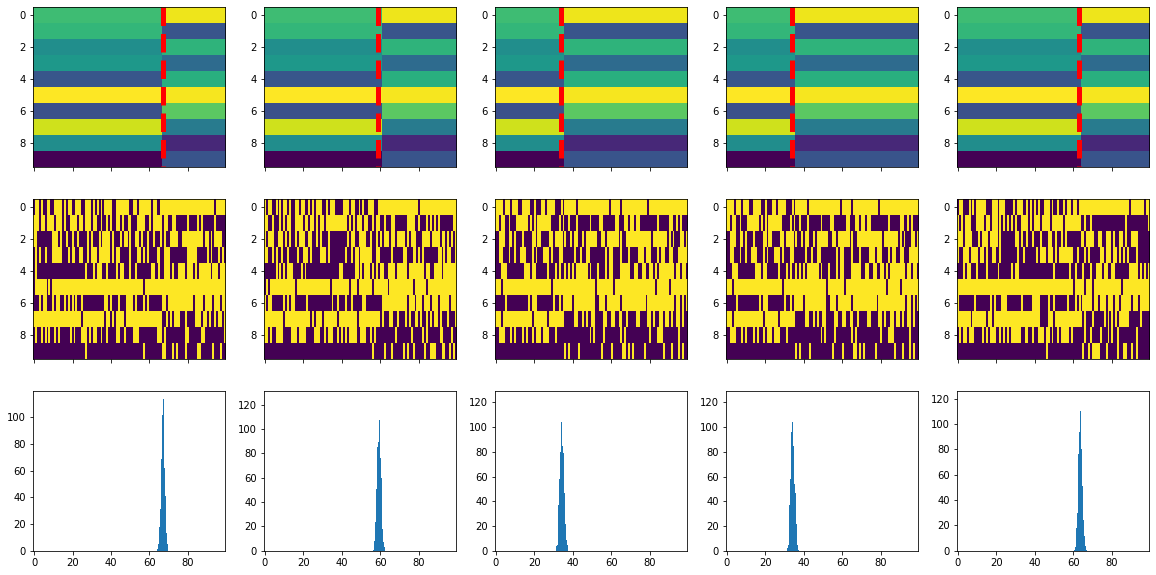

In [197]:
fig,ax = plt.subplots(3,trial_count,sharex=True,figsize=(20,10))
for trial_num,this_trial_ind in enumerate(trial_inds):
    ax[0,trial_num].imshow(true_r[this_trial_ind],aspect='auto')
    ax[1,trial_num].imshow(data_array[this_trial_ind],aspect='auto')
    
    for tau_num, this_tau in enumerate(tau[:,this_trial_ind].T):
        ax[2,trial_num].hist(this_tau,bins=50)
        ax[0,trial_num].vlines(mode_tau[this_trial_ind,tau_num],-0.5,nrns-0.5,color='red',alpha=1,linewidth=5, linestyles='dashed')